## Incorporate experiments that produce high amounts of variability in old age

- klothos
- wheel
- old age longtogeny
- old age longtogeny v2

In [1]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure, save_factory, PlotConfig, format_plots, ONTOGENY_AGE_CMAP, add_identity, legend
from scipy.spatial.distance import jensenshannon

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "syllable-troubleshooting", tight_layout=False)

In [3]:
def load_df():
    df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/ontogeny_males_syllable_df_v00.parquet')
    df, umap = relabel_by_usage(df)
    usages = df.groupby(['age', 'subject_name', 'date'])['relabeled_syllables'].value_counts(normalize=True)
    usage_mtx = pd.pivot_table(usages.reset_index(), index=['age', 'subject_name', 'date'], columns='relabeled_syllables', values='proportion', fill_value=0)
    return usage_mtx, umap

In [4]:
usage_mtx, syll_map = load_df()

In [5]:
keep_sylls = usage_mtx.quantile(0.9) > 0.01
keep_sylls = keep_sylls[keep_sylls].index

In [6]:
def load_klotho_df(syll_map):
    df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/klothos_syllable_df_v00.parquet')
    df['relabeled_syllables'] = df['syllables'].map(syll_map)
    usages = df.query('onsets').groupby(['subject_name', 'date'])['relabeled_syllables'].value_counts(normalize=True)
    usage_mtx = pd.pivot_table(usages.reset_index(), index=['subject_name', 'date'], columns='relabeled_syllables', values='proportion', fill_value=0)
    return usage_mtx

In [7]:
def load_wheel_df(syll_map):
    df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/wheel_syllable_df_v00.parquet')
    df['relabeled_syllables'] = df['syllables'].map(syll_map)
    usages = df.query('onsets').groupby(['subject_name', 'date'])['relabeled_syllables'].value_counts(normalize=True)
    usage_mtx = pd.pivot_table(usages.reset_index(), index=['subject_name', 'date'], columns='relabeled_syllables', values='proportion', fill_value=0)
    return usage_mtx

In [8]:
klotho_mtx = load_klotho_df(syll_map)

In [9]:
wheel_mtx = load_wheel_df(syll_map)

In [10]:
long_usages = pd.read_parquet("/n/groups/datta/win/longtogeny/data/ontogeny/version_08/longtogeny_males_clean_v1.parquet").fillna(0).astype('float32')
long_usages = long_usages[long_usages.index.get_level_values('age') < 600]
long_usages = long_usages[(long_usages.index.get_level_values("age") / 7) > 50]

In [11]:
age = usage_mtx.index.get_level_values('age')

In [12]:
mdl = umap.UMAP(metric=jensenshannon, n_neighbors=15, random_state=0)
latents = mdl.fit_transform(usage_mtx[keep_sylls])

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/umap_.py:1849: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [13]:
klotho_latents = mdl.transform(klotho_mtx.reindex(columns=keep_sylls, fill_value=0))
wheel_latents = mdl.transform(wheel_mtx.reindex(columns=keep_sylls, fill_value=0))

long_latents = mdl.transform(long_usages.reindex(columns=keep_sylls, fill_value=0))

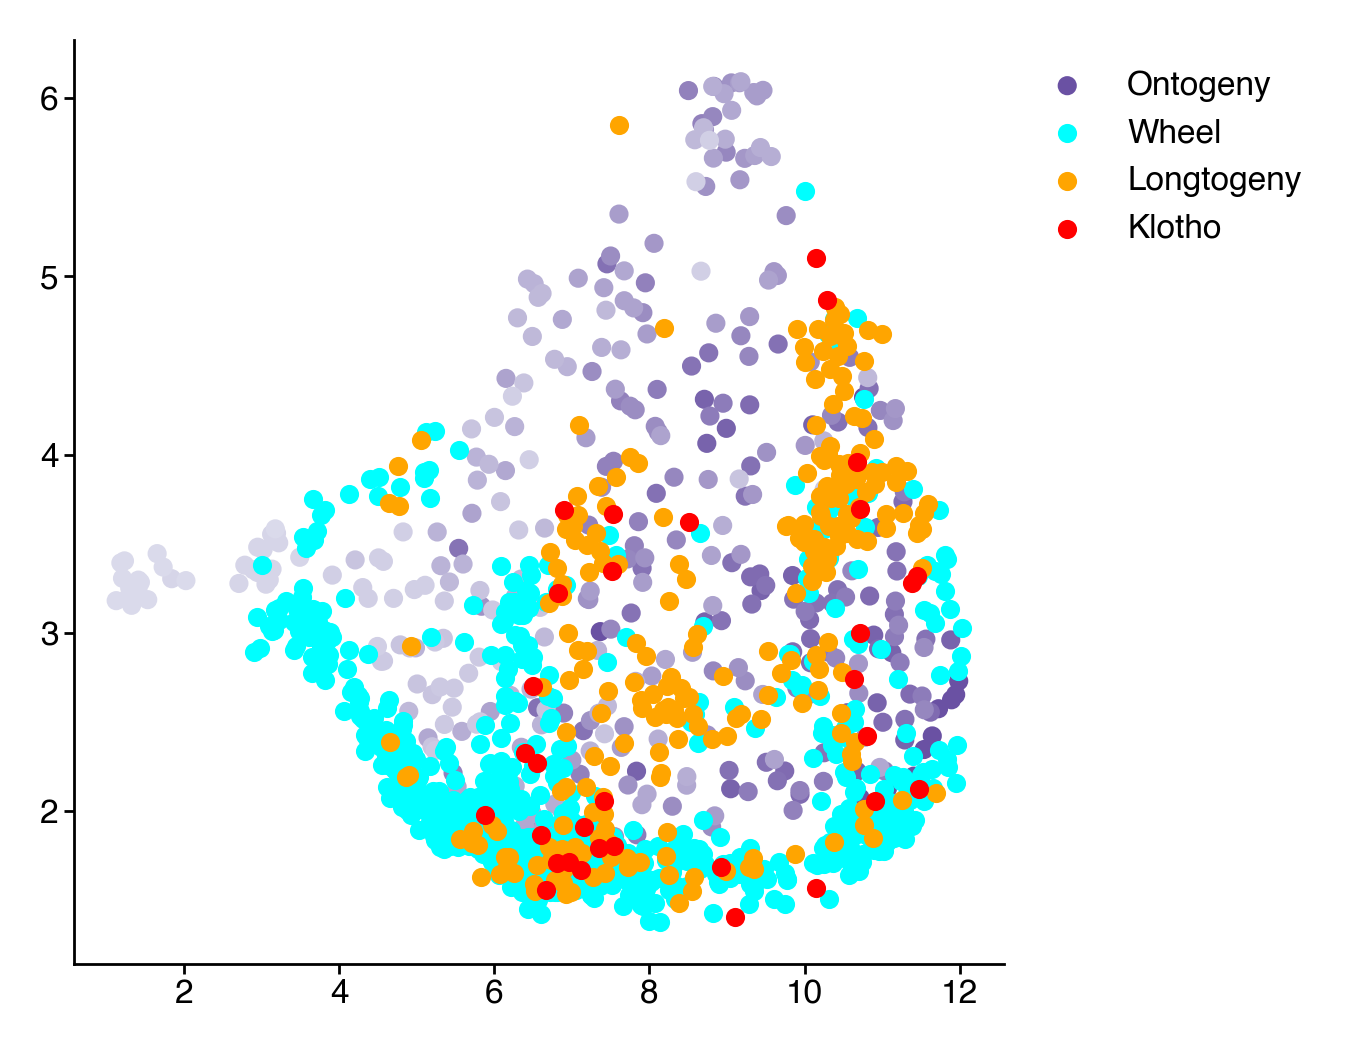

In [14]:
s = 7
plt.scatter(
    *latents[::-1].T, c=age[::-1], cmap=ONTOGENY_AGE_CMAP, s=s, label="Ontogeny"
)
plt.scatter(*wheel_latents.T, c="cyan", s=s, label="Wheel")
plt.scatter(*long_latents.T, c="orange", s=s, label="Longtogeny")
plt.scatter(*klotho_latents.T, c="r", s=s, label="Klotho")
legend()
sns.despine()

In [15]:
combined = pd.concat([usage_mtx, wheel_mtx, klotho_mtx, long_usages]).fillna(0)

In [22]:
mdl = umap.UMAP(metric=jensenshannon, n_neighbors=20, random_state=0, n_jobs=1)
latents = mdl.fit_transform(combined[keep_sylls])

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/umap_.py:1849: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


In [23]:
ont_latents = mdl.transform(usage_mtx.reindex(columns=keep_sylls, fill_value=0))
klotho_latents = mdl.transform(klotho_mtx.reindex(columns=keep_sylls, fill_value=0))
wheel_latents = mdl.transform(wheel_mtx.reindex(columns=keep_sylls, fill_value=0))
long_latents = mdl.transform(long_usages.reindex(columns=keep_sylls, fill_value=0))

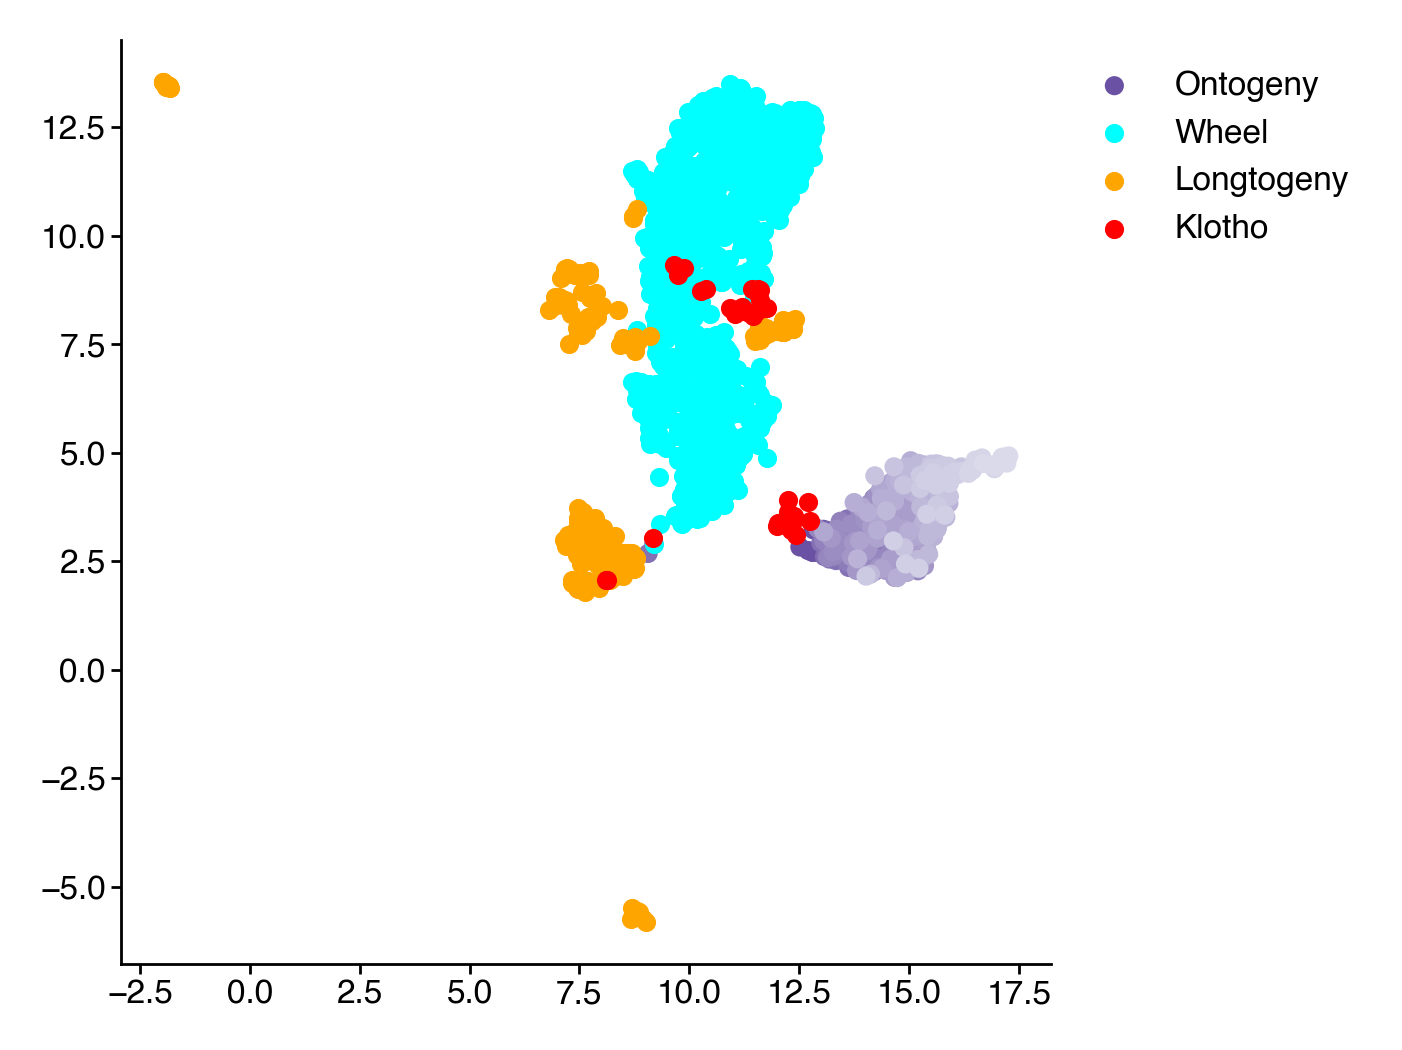

In [24]:
s = 7
plt.scatter(
    *ont_latents[::-1].T, c=age[::-1], cmap=ONTOGENY_AGE_CMAP, s=s, label="Ontogeny"
)
plt.scatter(*wheel_latents.T, c="cyan", s=s, label="Wheel")
plt.scatter(*long_latents.T, c="orange", s=s, label="Longtogeny")
plt.scatter(*klotho_latents.T, c="r", s=s, label="Klotho")
legend()
sns.despine()

In [25]:
from sklearn.decomposition import PCA

In [30]:
pca = PCA()
pcs = pca.fit_transform(combined[keep_sylls])

In [31]:
ont_latents = pca.transform(usage_mtx.reindex(columns=keep_sylls, fill_value=0))
klotho_latents = pca.transform(klotho_mtx.reindex(columns=keep_sylls, fill_value=0))
wheel_latents = pca.transform(wheel_mtx.reindex(columns=keep_sylls, fill_value=0))
long_latents = pca.transform(long_usages.reindex(columns=keep_sylls, fill_value=0))

In [32]:
pcs.shape

(1588, 67)

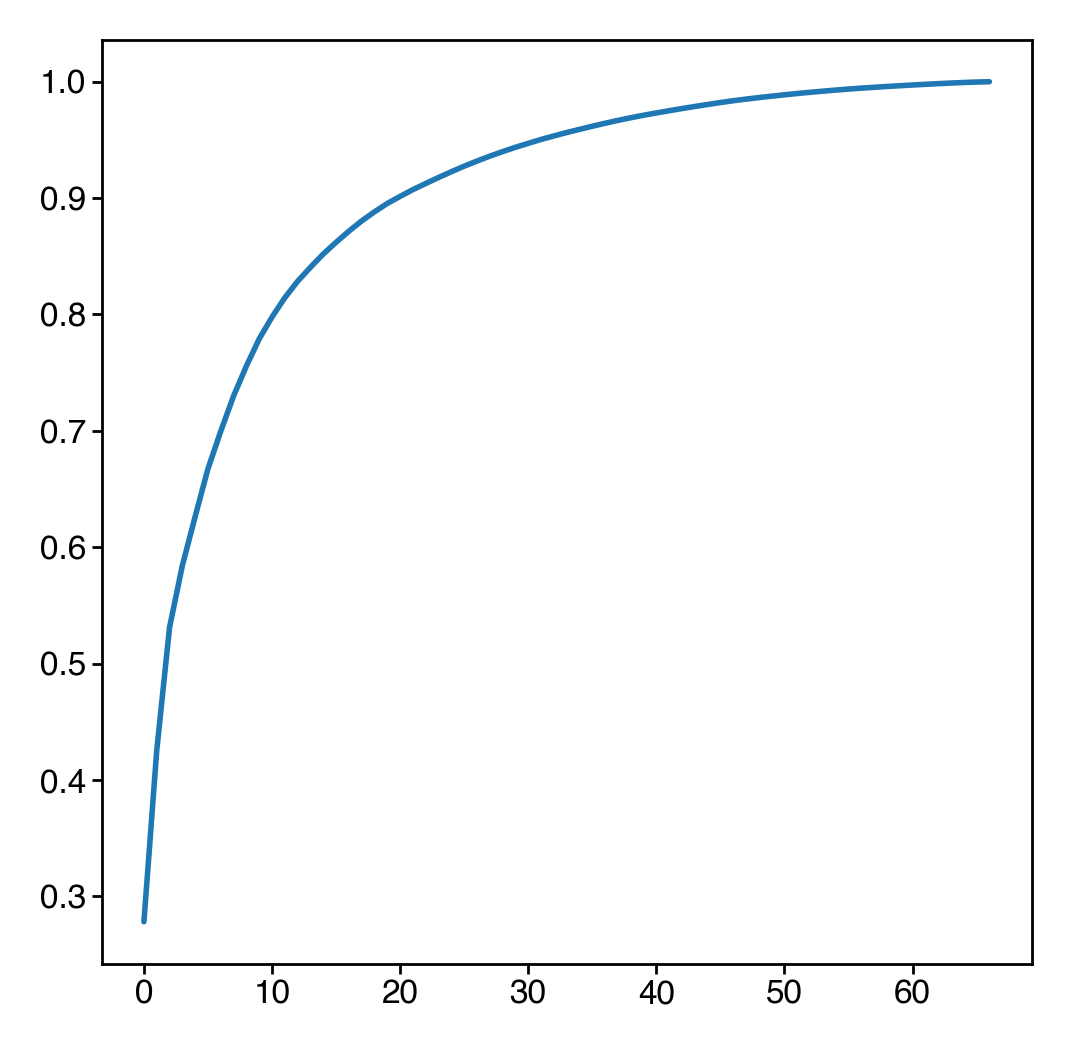

In [41]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [42]:
pca.explained_variance_ratio_[:6]

array([0.27812721, 0.14707936, 0.10587328, 0.05313172, 0.04209254,
       0.04109542])

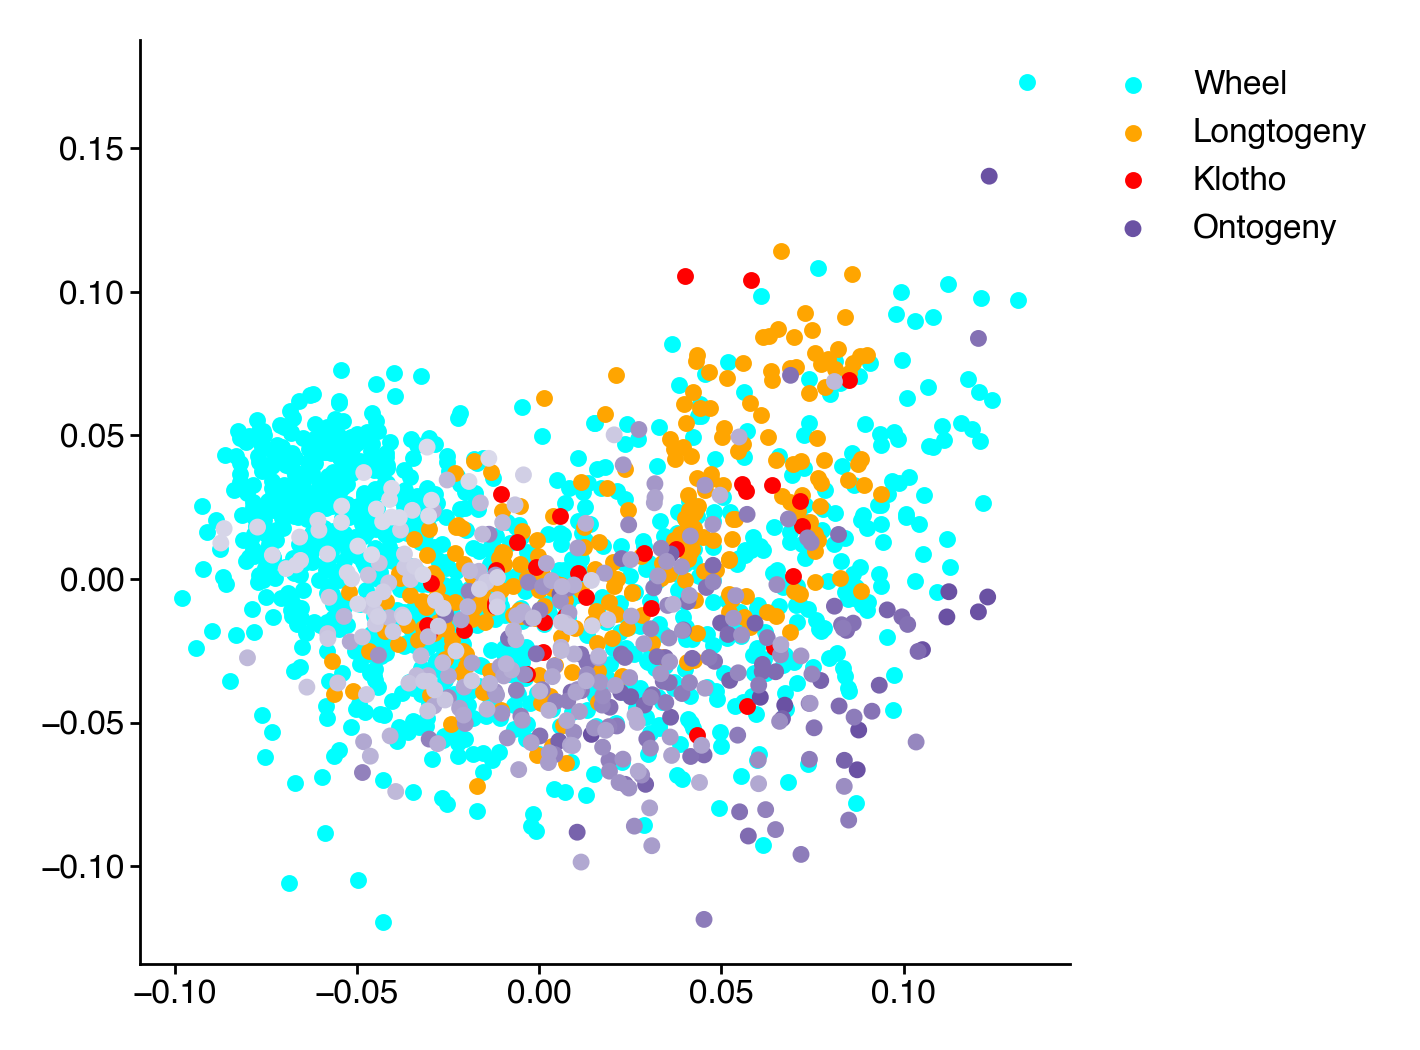

In [40]:
s = 5
plt.scatter(*wheel_latents.T[:2], c="cyan", s=s, label="Wheel")
plt.scatter(*long_latents.T[:2], c="orange", s=s, label="Longtogeny")
plt.scatter(*klotho_latents.T[:2], c="r", s=s, label="Klotho")
plt.scatter(
    *ont_latents[::-1].T[:2], c=age[::-1], cmap=ONTOGENY_AGE_CMAP, s=s, label="Ontogeny"
)
legend()
sns.despine()

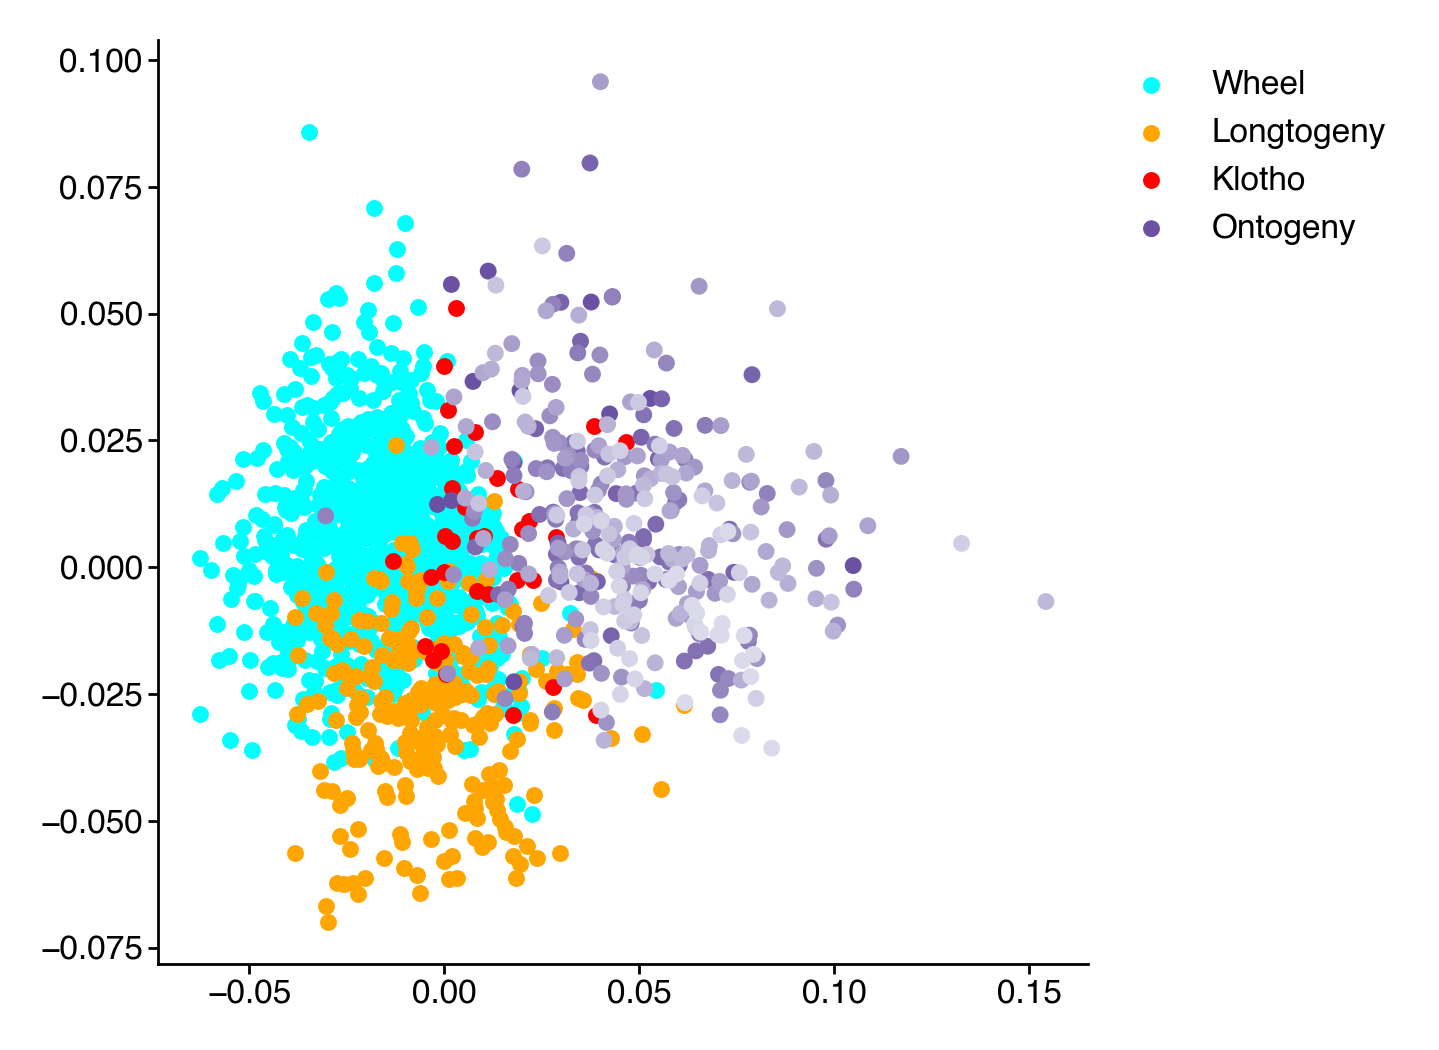

In [39]:
s = 5
plt.scatter(*wheel_latents.T[2:4], c="cyan", s=s, label="Wheel")
plt.scatter(*long_latents.T[2:4], c="orange", s=s, label="Longtogeny")
plt.scatter(*klotho_latents.T[2:4], c="r", s=s, label="Klotho")
plt.scatter(
    *ont_latents[::-1].T[2:4], c=age[::-1], cmap=ONTOGENY_AGE_CMAP, s=s, label="Ontogeny"
)
legend()
sns.despine()

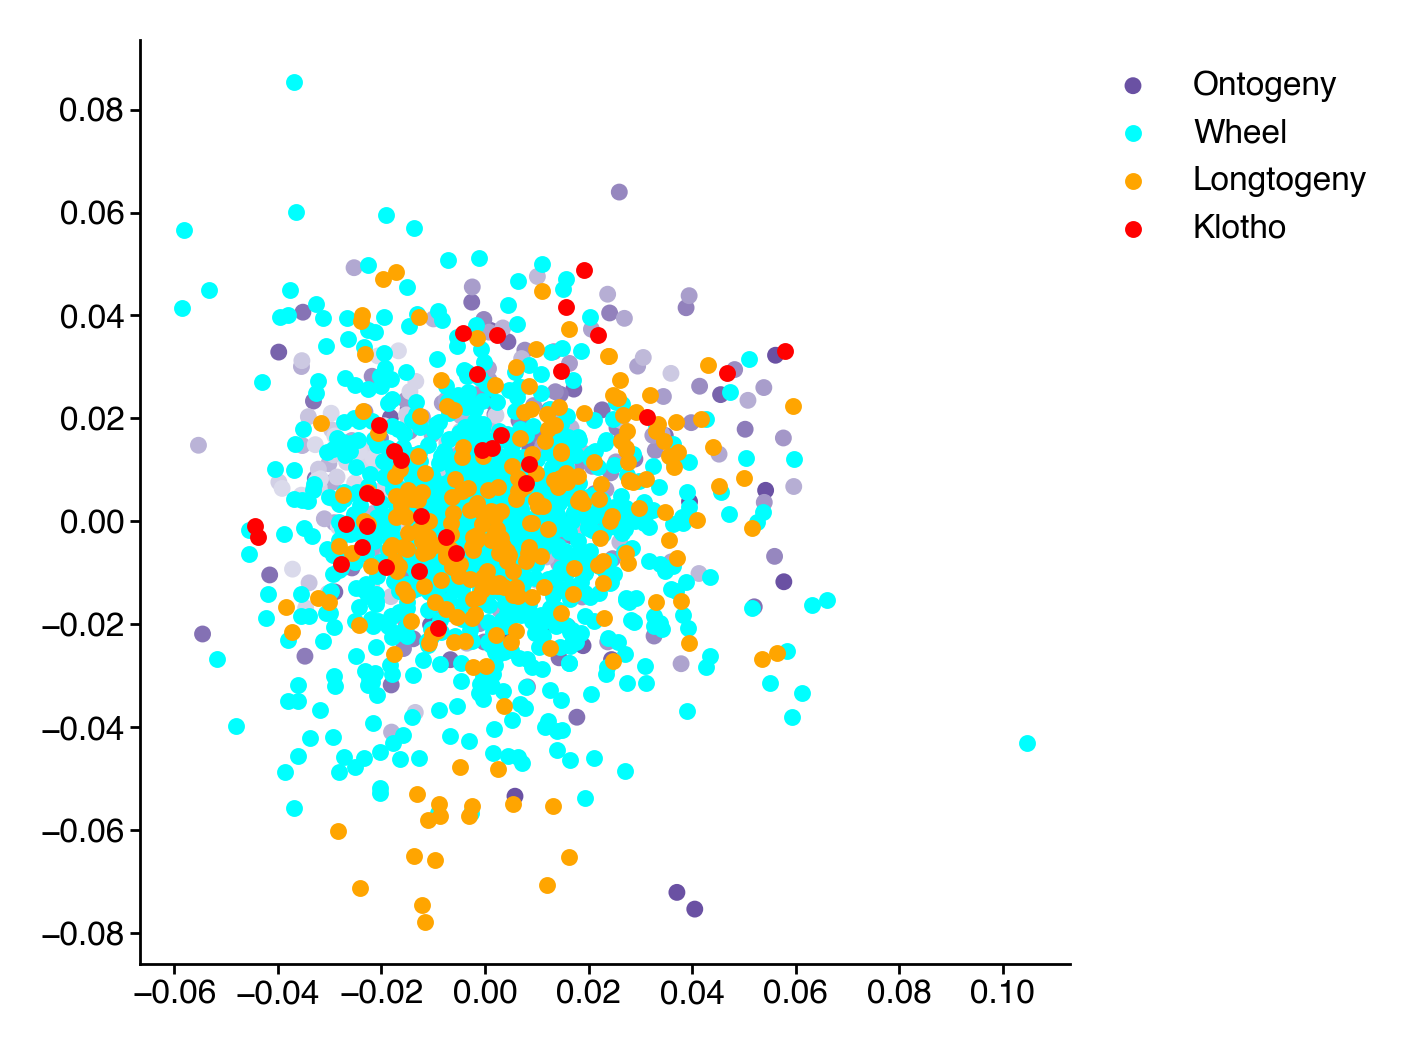

In [37]:
s = 5
plt.scatter(
    *ont_latents[::-1].T[4:6], c=age[::-1], cmap=ONTOGENY_AGE_CMAP, s=s, label="Ontogeny"
)
plt.scatter(*wheel_latents.T[4:6], c="cyan", s=s, label="Wheel")
plt.scatter(*long_latents.T[4:6], c="orange", s=s, label="Longtogeny")
plt.scatter(*klotho_latents.T[4:6], c="r", s=s, label="Klotho")
legend()
sns.despine()

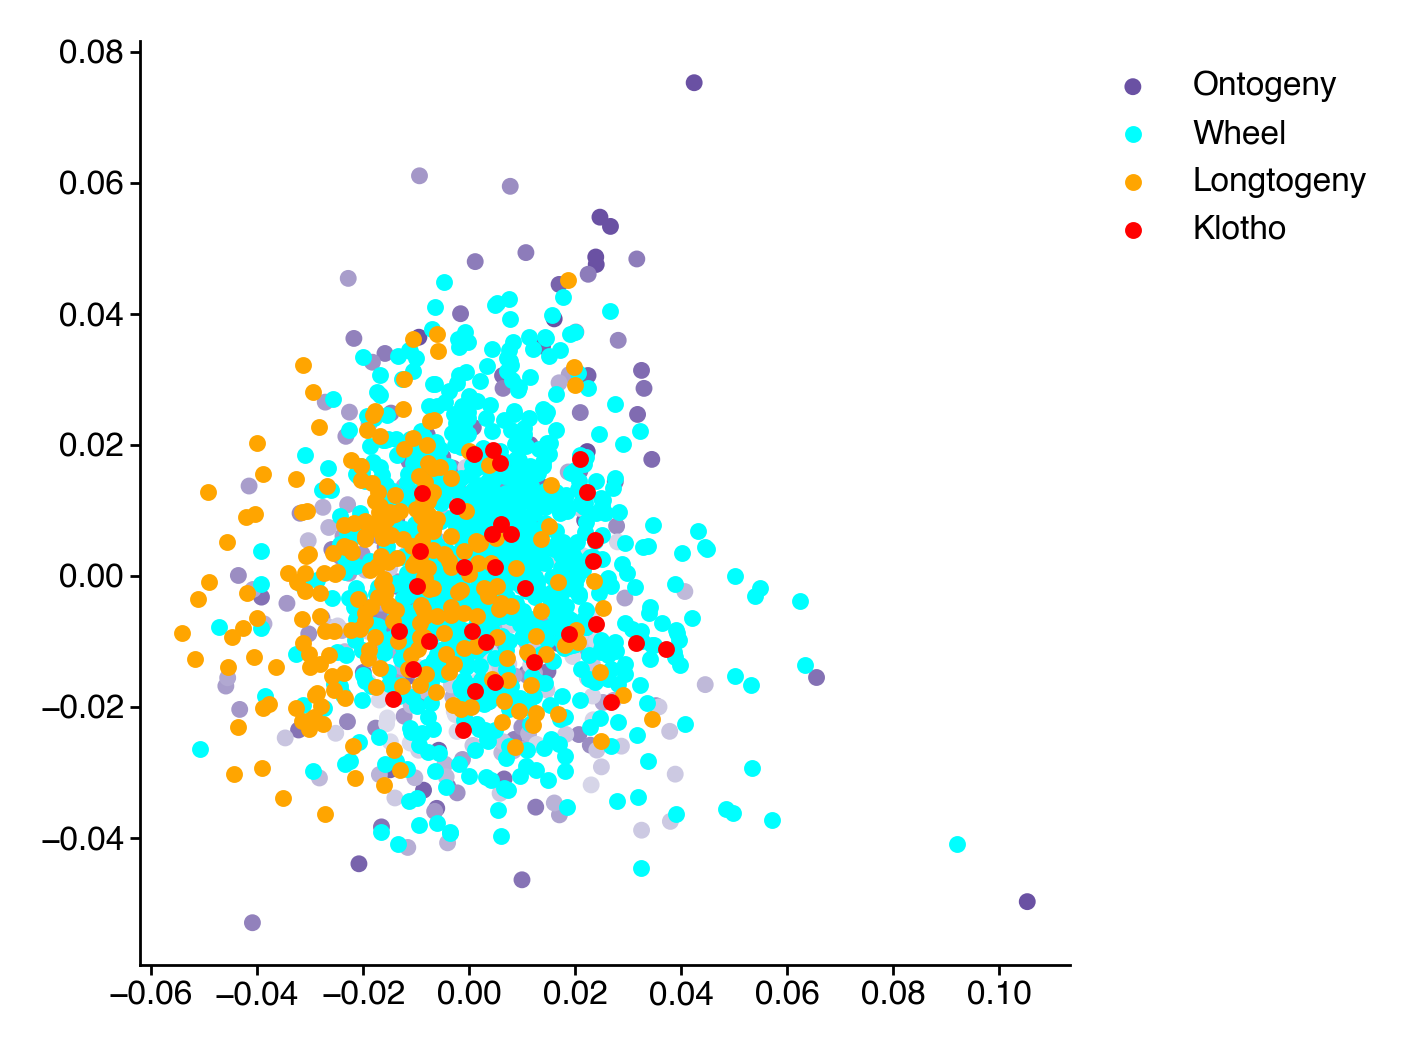

In [38]:
s = 5
plt.scatter(
    *ont_latents[::-1].T[6:8], c=age[::-1], cmap=ONTOGENY_AGE_CMAP, s=s, label="Ontogeny"
)
plt.scatter(*wheel_latents.T[6:8], c="cyan", s=s, label="Wheel")
plt.scatter(*long_latents.T[6:8], c="orange", s=s, label="Longtogeny")
plt.scatter(*klotho_latents.T[6:8], c="r", s=s, label="Klotho")
legend()
sns.despine()